Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result. 

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/mitsuhazuki/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 405, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 405 (delta 45), reused 7 (delta 0), pack-reused 289
Receiving objects: 100% (405/405), 314.26 MiB | 2.82 MiB/s, done.
Resolving deltas: 100% (200/200), done.
Updating files: 100% (58/58), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import libs

In [ ]:
import pickle

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from models.downsampler import Downsampler

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1 
factor = 4 # 8
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two (32 in this case)
PLOT = True

# To produce images from the paper we took *_GT.png images from LapSRN viewer for corresponding factor,
# e.g. x4/zebra_GT.png for factor=4, and x8/zebra_GT.png for factor=8 
path_to_image = 'data/sr/zebra_GT.png'

# Load image and baselines

HR and LR resolutions: (576, 384), (144, 96)


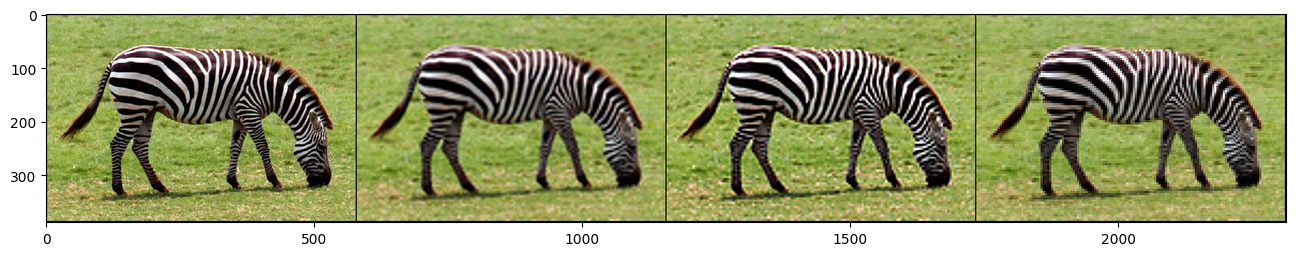

PSNR bicubic: 23.1048   PSNR nearest: 20.8212


In [4]:
# Starts here
imgs = load_LR_HR_imgs_sr(path_to_image , imsize, factor, enforse_div32)

imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])

if PLOT:
    plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np']], 4,12);
    print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
                                        peak_signal_noise_ratio(imgs['HR_np'], imgs['bicubic_np']), 
                                        peak_signal_noise_ratio(imgs['HR_np'], imgs['nearest_np'])))

In [ ]:
pickle.dump( imgs['HR_np'], open( "/content/drive/MyDrive/Deep_Image_Prior/SR/HR_np.p", "wb" ))
pickle.dump( imgs['LR_np'], open( "/content/drive/MyDrive/Deep_Image_Prior/SR/LR_np.p", "wb" ))

# Set up parameters and net

In [14]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

if factor == 4: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

In [15]:
# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

# Define closure and optimize

In [16]:
net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

NET_TYPE = 'skip' # UNet, ResNet
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

def closure():
    global i, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
        
    total_loss.backward()

    # Log
    psnr_LR = peak_signal_noise_ratio(imgs['LR_np'], torch_to_np(out_LR))
    psnr_HR = peak_signal_noise_ratio(imgs['HR_np'], torch_to_np(out_HR))
    print ('\rIteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), end='')
                      
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if PLOT and i % 100 == 0:
        out_HR_np = torch_to_np(out_HR)
        plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)

    i += 1
    
    return total_loss


psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

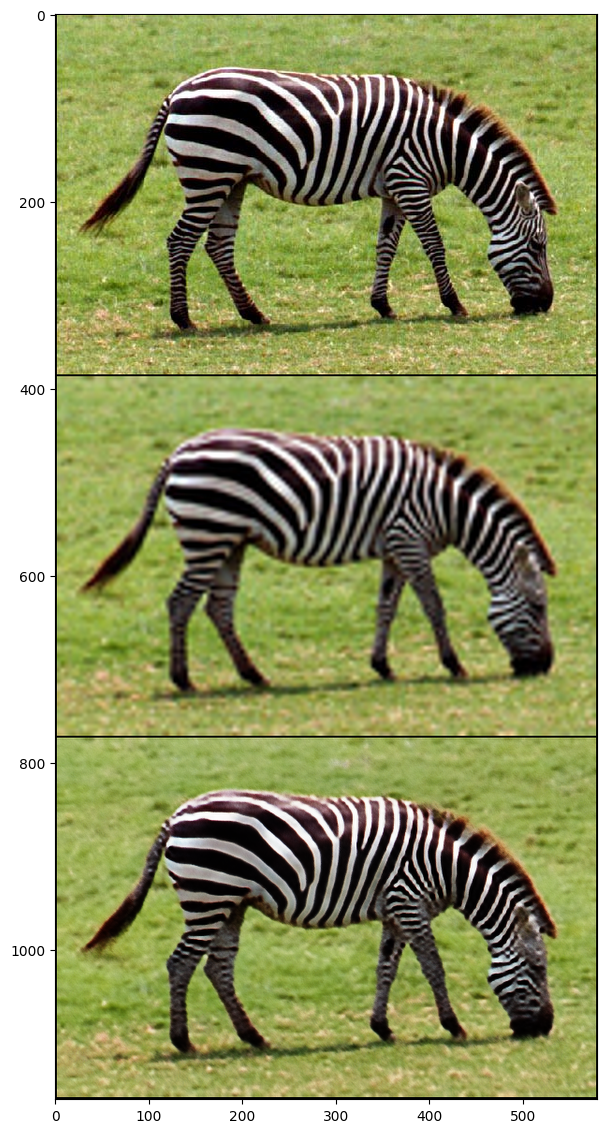

In [18]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])

# For the paper we acually took `_bicubic.png` files from LapSRN viewer and used `result_deep_prior` as our result
plot_image_grid([imgs['HR_np'],
                 imgs['bicubic_np'],
                 out_HR_np], factor=4, nrow=1);

In [ ]:
list_out_np = []

In [ ]:
list_out_np = pickle.load( open( "/content/drive/MyDrive/Deep_Image_Prior/SR/list_out_np.p", "rb" ))

In [ ]:
list_out_np.append(out_HR_np)
pickle.dump( list_out_np, open( "/content/drive/MyDrive/Deep_Image_Prior/SR/list_out_np.p", "wb" ))